# 🚀 Advanced Feature Engineering: Features Derivadas

**Objetivo:** Crear features derivadas de las existentes para mejorar el poder predictivo del modelo

**Input:**
- `../data/processed/crohn/ml_dataset.csv`
- `../data/processed/cu/ml_dataset.csv`

**Output:** Datasets enriquecidos con features derivadas:
- `../data/processed/crohn/ml_dataset_enhanced.csv`
- `../data/processed/cu/ml_dataset_enhanced.csv`

**Features Derivadas:**
1. **Symptom Aggregations** (total_symptom_score, gi_score, systemic_score)
2. **Temporal Features** (symptom trends, volatility, days_since_low_symptoms)
3. **History Features** (flare_frequency, recency_score)
4. **Interactions** (pain_diarrhea_combo, vulnerable_state)
5. **Red Flags** (alarming symptoms combination)

**Autor:** Asier Ortiz García  
**Fecha:** Noviembre 2025

## 📦 Imports y Configuración

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
%matplotlib inline

print("=" * 80)
print("ADVANCED FEATURE ENGINEERING")
print("=" * 80)

ADVANCED FEATURE ENGINEERING


## 🔧 Funciones de Feature Engineering

In [2]:
def create_symptom_aggregations(df, ibd_type='crohn'):
    """
    Crea features agregadas de síntomas.
    
    Features:
    - total_symptom_score: Suma ponderada de todos los síntomas
    - gi_score: Score gastrointestinal (dolor + diarrea + náusea)
    - systemic_score: Score sistémico (fatiga + fiebre)
    - red_flag_score: Síntomas de alarma (sangre + fiebre)
    """
    df = df.copy()
    
    # Total Symptom Score (weighted)
    # Pesos diferentes para Crohn vs UC
    if ibd_type == 'crohn':
        df['total_symptom_score'] = (
            df['abdominal_pain'] * 1.2 +
            df['diarrhea'] * 1.3 +
            df['fatigue'] * 1.0 +
            df['nausea'] * 0.8 +
            df['blood_in_stool'] * 2.0 +
            df['fever'] * 1.5
        )
    else:  # UC - sangre y diarrea pesan más
        df['total_symptom_score'] = (
            df['abdominal_pain'] * 1.0 +
            df['diarrhea'] * 1.5 +
            df['fatigue'] * 1.0 +
            df['nausea'] * 0.8 +
            df['blood_in_stool'] * 2.5 +  # Más peso en UC
            df['fever'] * 1.5
        )
    
    # GI Score (solo síntomas gastrointestinales)
    df['gi_score'] = (
        df['abdominal_pain'] +
        df['diarrhea'] +
        df['nausea'] +
        (df['blood_in_stool'] * 2)  # Sangre es muy importante
    )
    
    # Systemic Score (síntomas sistémicos)
    df['systemic_score'] = (
        df['fatigue'] +
        (df['fever'] * 2)  # Fiebre es alarma
    )
    
    # Red Flag Score (combinación de síntomas de alarma)
    df['red_flag_score'] = (
        (df['blood_in_stool'] == 1.0).astype(int) * 3 +
        (df['fever'] == 1.0).astype(int) * 2 +
        (df['abdominal_pain'] >= 0.7).astype(int) * 1  # Pain >= 7/10
    )
    
    # Symptom Count (número de síntomas activos)
    df['symptom_count'] = (
        (df['abdominal_pain'] > 0.2).astype(int) +
        (df['diarrhea'] > 0.2).astype(int) +
        (df['fatigue'] > 0.2).astype(int) +
        (df['nausea'] > 0.2).astype(int) +
        (df['blood_in_stool'] > 0).astype(int) +
        (df['fever'] > 0).astype(int)
    )
    
    return df

print("✓ Función de agregaciones de síntomas definida")

✓ Función de agregaciones de síntomas definida


In [3]:
def create_temporal_features(df, window_days=7):
    """
    Crea features temporales basadas en el historial del usuario.
    
    Features:
    - pain_trend_7d: Tendencia del dolor últimos 7 días
    - diarrhea_trend_7d: Tendencia de diarrea últimos 7 días
    - symptom_volatility_7d: Variabilidad de síntomas
    - days_since_low_symptoms: Días consecutivos con síntomas
    - symptom_change_rate: Tasa de cambio de síntomas
    """
    df = df.copy()
    df = df.sort_values(['user_id', 'checkin_date'])
    
    # Rolling means (trends)
    df['pain_trend_7d'] = df.groupby('user_id')['abdominal_pain'].transform(
        lambda x: x.rolling(window_days, min_periods=1).mean()
    )
    
    df['diarrhea_trend_7d'] = df.groupby('user_id')['diarrhea'].transform(
        lambda x: x.rolling(window_days, min_periods=1).mean()
    )
    
    df['fatigue_trend_7d'] = df.groupby('user_id')['fatigue'].transform(
        lambda x: x.rolling(window_days, min_periods=1).mean()
    )
    
    # Volatility (std deviation)
    df['symptom_volatility_7d'] = df.groupby('user_id')['total_symptom_score'].transform(
        lambda x: x.rolling(window_days, min_periods=1).std().fillna(0)
    )
    
    # Change rate (síntomas hoy vs hace 7 días)
    df['symptom_change_rate'] = df.groupby('user_id')['total_symptom_score'].transform(
        lambda x: x.diff(window_days).fillna(0)
    )
    
    # Days since good day (consecutive days with symptoms)
    df['is_bad_day'] = (df['total_symptom_score'] > 3.0).astype(int)
    
    def calc_consecutive_bad_days(group):
        group = group.sort_values('checkin_date')
        consecutive = []
        count = 0
        
        for is_bad in group['is_bad_day']:
            if is_bad:
                count += 1
            else:
                count = 0
            consecutive.append(count)
        
        group['days_since_low_symptoms'] = consecutive
        return group
    
    df = df.groupby('user_id', group_keys=False).apply(calc_consecutive_bad_days)
    
    return df

print("✓ Función de features temporales definida")

✓ Función de features temporales definida


In [4]:
def create_history_features(df):
    """
    Crea features derivadas del historial médico.
    
    Features:
    - flare_frequency: Previous flares / años con enfermedad
    - recency_score: Qué tan reciente fue el último brote (0-1)
    - disease_burden: Combinación de duración + flares
    - age_disease_interaction: Enfermedad temprana
    """
    df = df.copy()
    
    # Flare frequency (flares por año)
    df['flare_frequency'] = df['previous_flares'] / df['disease_duration_years'].clip(lower=1)
    
    # Recency score (más reciente = más riesgo)
    # Usa función exponencial: reciente (7 días) = 0.9, lejano (365 días) = 0.08
    df['recency_score'] = 1 / (1 + df['last_flare_days_ago'] / 30)
    
    # Disease burden (carga de enfermedad)
    df['disease_burden'] = (
        df['disease_duration_years'] * 0.3 +
        df['previous_flares'] * 0.7
    )
    
    # Young with long duration (enfermedad temprana puede ser más agresiva)
    df['young_longduration'] = (
        (df['age'] < 30) & (df['disease_duration_years'] > 5)
    ).astype(int)
    
    return df

print("✓ Función de features de historial definida")

✓ Función de features de historial definida


In [5]:
def create_interaction_features(df):
    """
    Crea features de interacción entre variables.
    
    Features:
    - pain_diarrhea_combo: Dolor × Diarrea (brote típico)
    - blood_and_pain: Sangre + dolor alto (alarma)
    - vulnerable_state: Brote reciente + síntomas altos
    - symptom_severity_category: Categoría de severidad (0=mild, 1=moderate, 2=severe)
    """
    df = df.copy()
    
    # Pain × Diarrhea (ambos altos = brote clásico)
    df['pain_diarrhea_combo'] = df['abdominal_pain'] * df['diarrhea']
    
    # Blood + high pain (combinación peligrosa)
    df['blood_and_pain'] = (
        (df['blood_in_stool'] == 1.0) & (df['abdominal_pain'] >= 0.6)
    ).astype(int)
    
    # Vulnerable state (brote reciente + síntomas actuales altos)
    df['vulnerable_state'] = (
        (df['last_flare_days_ago'] < 180) & (df['total_symptom_score'] > 4.0)
    ).astype(int)
    
    # Symptom severity category
    def categorize_severity(score):
        if score < 3.0:
            return 0  # Mild
        elif score < 6.0:
            return 1  # Moderate
        else:
            return 2  # Severe
    
    df['symptom_severity_category'] = df['total_symptom_score'].apply(categorize_severity)
    
    # GI dominance (síntomas GI más fuertes que sistémicos)
    df['gi_dominant'] = (df['gi_score'] > df['systemic_score'] * 1.5).astype(int)
    
    return df

print("✓ Función de features de interacción definida")

✓ Función de features de interacción definida


In [6]:
def create_all_derived_features(df, ibd_type='crohn'):
    """
    Aplica todas las transformaciones de feature engineering.
    """
    print(f"\n🔧 Creando features derivadas para {ibd_type.upper()}...")
    print(f"  Input: {len(df):,} registros")
    
    # 1. Symptom aggregations
    print("  1️⃣ Agregaciones de síntomas...")
    df = create_symptom_aggregations(df, ibd_type)
    
    # 2. Temporal features (requiere orden por fecha)
    print("  2️⃣ Features temporales...")
    df = create_temporal_features(df)
    
    # 3. History features
    print("  3️⃣ Features de historial...")
    df = create_history_features(df)
    
    # 4. Interaction features
    print("  4️⃣ Features de interacción...")
    df = create_interaction_features(df)
    
    print(f"  ✅ Output: {len(df):,} registros, {len(df.columns)} columnas")
    
    return df

print("✓ Función principal de feature engineering definida")

✓ Función principal de feature engineering definida


## 📊 Procesar Dataset de Crohn

In [7]:
print("\n" + "="*80)
print("CROHN DATASET")
print("="*80)

# Cargar
df_crohn = pd.read_csv('../data/processed/crohn/ml_dataset.csv')
df_crohn['checkin_date'] = pd.to_datetime(df_crohn['checkin_date'])

print(f"\n📂 Cargado: {len(df_crohn):,} registros")
print(f"  Usuarios: {df_crohn['user_id'].nunique():,}")
print(f"  Columnas originales: {len(df_crohn.columns)}")

# Feature engineering
df_crohn_enhanced = create_all_derived_features(df_crohn, ibd_type='crohn')

print(f"\n✅ Features añadidas: {len(df_crohn_enhanced.columns) - len(df_crohn.columns)}")


CROHN DATASET

📂 Cargado: 7,618 registros
  Usuarios: 897
  Columnas originales: 16

🔧 Creando features derivadas para CROHN...
  Input: 7,618 registros
  1️⃣ Agregaciones de síntomas...
  2️⃣ Features temporales...
  3️⃣ Features de historial...
  4️⃣ Features de interacción...
  ✅ Output: 7,618 registros, 37 columnas

✅ Features añadidas: 21


In [8]:
# Mostrar nuevas features
new_features = [col for col in df_crohn_enhanced.columns if col not in df_crohn.columns]

print("\n📊 Nuevas Features Creadas:")
for i, feat in enumerate(new_features, 1):
    print(f"  {i}. {feat}")

# Estadísticas de nuevas features
print("\n📈 Estadísticas de Features Derivadas:")
print(df_crohn_enhanced[new_features[:10]].describe().round(2))


📊 Nuevas Features Creadas:
  1. total_symptom_score
  2. gi_score
  3. systemic_score
  4. red_flag_score
  5. symptom_count
  6. pain_trend_7d
  7. diarrhea_trend_7d
  8. fatigue_trend_7d
  9. symptom_volatility_7d
  10. symptom_change_rate
  11. is_bad_day
  12. days_since_low_symptoms
  13. flare_frequency
  14. recency_score
  15. disease_burden
  16. young_longduration
  17. pain_diarrhea_combo
  18. blood_and_pain
  19. vulnerable_state
  20. symptom_severity_category
  21. gi_dominant

📈 Estadísticas de Features Derivadas:
       total_symptom_score  gi_score  systemic_score  red_flag_score  \
count              7618.00   7618.00         7618.00         7618.00   
mean                  1.16      0.71            0.35            0.34   
std                   0.94      0.66            0.40            0.52   
min                   0.00      0.00            0.00            0.00   
25%                   0.40      0.25            0.00            0.00   
50%                   0.90     

In [9]:
# Guardar dataset enriquecido
output_path = '../data/processed/crohn/ml_dataset_enhanced.csv'
df_crohn_enhanced.to_csv(output_path, index=False)

print(f"\n💾 Dataset guardado: {output_path}")
print(f"  {len(df_crohn_enhanced):,} registros × {len(df_crohn_enhanced.columns)} columnas")


💾 Dataset guardado: ../data/processed/crohn/ml_dataset_enhanced.csv
  7,618 registros × 37 columnas


## 📊 Procesar Dataset de CU

In [10]:
print("\n" + "="*80)
print("CU DATASET")
print("="*80)

# Cargar
df_cu = pd.read_csv('../data/processed/cu/ml_dataset.csv')
df_cu['checkin_date'] = pd.to_datetime(df_cu['checkin_date'])

print(f"\n📂 Cargado: {len(df_cu):,} registros")
print(f"  Usuarios: {df_cu['user_id'].nunique():,}")
print(f"  Columnas originales: {len(df_cu.columns)}")

# Feature engineering
df_cu_enhanced = create_all_derived_features(df_cu, ibd_type='cu')

print(f"\n✅ Features añadidas: {len(df_cu_enhanced.columns) - len(df_cu.columns)}")


CU DATASET

📂 Cargado: 6,860 registros
  Usuarios: 589
  Columnas originales: 16

🔧 Creando features derivadas para CU...
  Input: 6,860 registros
  1️⃣ Agregaciones de síntomas...
  2️⃣ Features temporales...
  3️⃣ Features de historial...
  4️⃣ Features de interacción...
  ✅ Output: 6,860 registros, 37 columnas

✅ Features añadidas: 21


In [11]:
# Mostrar nuevas features
new_features = [col for col in df_cu_enhanced.columns if col not in df_cu.columns]

print("\n📊 Nuevas Features Creadas:")
for i, feat in enumerate(new_features, 1):
    print(f"  {i}. {feat}")

# Estadísticas de nuevas features
print("\n📈 Estadísticas de Features Derivadas:")
print(df_cu_enhanced[new_features[:10]].describe().round(2))


📊 Nuevas Features Creadas:
  1. total_symptom_score
  2. gi_score
  3. systemic_score
  4. red_flag_score
  5. symptom_count
  6. pain_trend_7d
  7. diarrhea_trend_7d
  8. fatigue_trend_7d
  9. symptom_volatility_7d
  10. symptom_change_rate
  11. is_bad_day
  12. days_since_low_symptoms
  13. flare_frequency
  14. recency_score
  15. disease_burden
  16. young_longduration
  17. pain_diarrhea_combo
  18. blood_and_pain
  19. vulnerable_state
  20. symptom_severity_category
  21. gi_dominant

📈 Estadísticas de Features Derivadas:
       total_symptom_score  gi_score  systemic_score  red_flag_score  \
count              6860.00   6860.00         6860.00         6860.00   
mean                  1.14      0.69            0.34            0.22   
std                   0.89      0.66            0.33            0.52   
min                   0.00      0.00            0.00            0.00   
25%                   0.50      0.25            0.00            0.00   
50%                   0.95     

In [12]:
# Guardar dataset enriquecido
output_path = '../data/processed/cu/ml_dataset_enhanced.csv'
df_cu_enhanced.to_csv(output_path, index=False)

print(f"\n💾 Dataset guardado: {output_path}")
print(f"  {len(df_cu_enhanced):,} registros × {len(df_cu_enhanced.columns)} columnas")


💾 Dataset guardado: ../data/processed/cu/ml_dataset_enhanced.csv
  6,860 registros × 37 columnas


## 📊 Análisis de Correlaciones

In [13]:
# Seleccionar features derivadas numéricas para correlación
derived_numeric_features = [
    'total_symptom_score', 'gi_score', 'systemic_score',
    'flare_frequency', 'recency_score', 'pain_diarrhea_combo',
    'symptom_volatility_7d', 'symptom_change_rate'
]

# Correlación con target (convertir risk_level a numérico)
risk_map = {'low': 0, 'medium': 1, 'high': 2}
df_crohn_enhanced['risk_numeric'] = df_crohn_enhanced['risk_level'].map(risk_map)

correlations = df_crohn_enhanced[derived_numeric_features + ['risk_numeric']].corr()['risk_numeric'].drop('risk_numeric').sort_values(ascending=False)

print("\n🔍 Correlación de Features Derivadas con Risk Level (Crohn):")
print("="*60)
for feat, corr in correlations.items():
    print(f"  {feat:30s}: {corr:+.3f}")


🔍 Correlación de Features Derivadas con Risk Level (Crohn):
  total_symptom_score           : +0.830
  gi_score                      : +0.757
  pain_diarrhea_combo           : +0.696
  systemic_score                : +0.522
  recency_score                 : +0.417
  flare_frequency               : +0.315
  symptom_volatility_7d         : +0.277
  symptom_change_rate           : +0.236


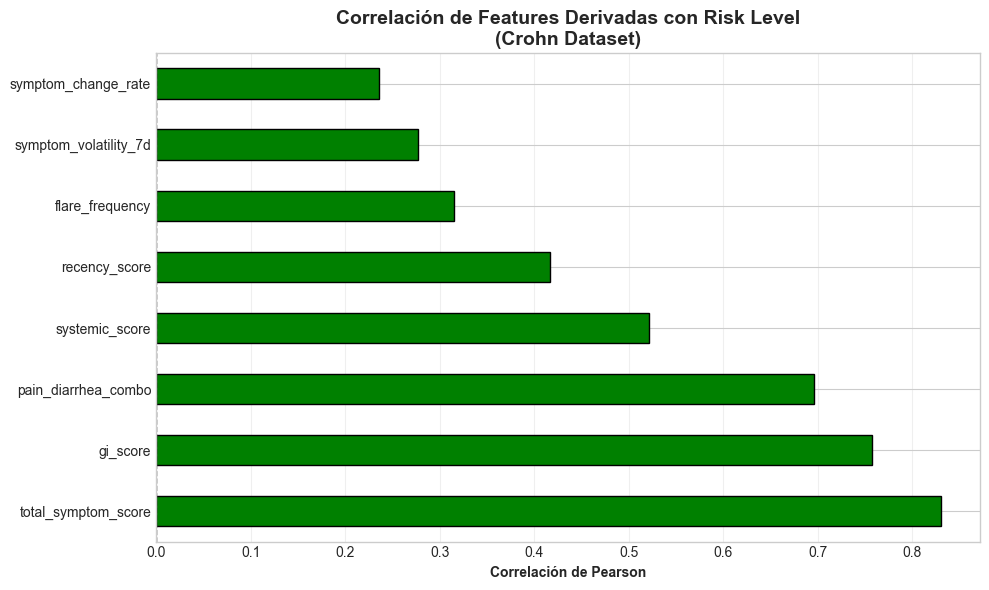


💾 Figura guardada: ../docs/figures/derived_features_correlation.png


In [14]:
# Visualización de correlaciones
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['red' if x < 0 else 'green' for x in correlations.values]
correlations.plot(kind='barh', ax=ax, color=colors, edgecolor='black')

ax.set_title('Correlación de Features Derivadas con Risk Level\n(Crohn Dataset)', 
             fontweight='bold', fontsize=14)
ax.set_xlabel('Correlación de Pearson', fontweight='bold')
ax.set_ylabel('')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../docs/figures/derived_features_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Figura guardada: ../docs/figures/derived_features_correlation.png")

## 📋 Resumen y Metadata

In [15]:
print("\n" + "="*80)
print("RESUMEN FINAL")
print("="*80)

# Lista de todas las features derivadas
derived_features = [
    col for col in df_crohn_enhanced.columns 
    if col not in df_crohn.columns and col != 'risk_numeric'
]

metadata = {
    "derived_features": derived_features,
    "categories": {
        "symptom_aggregations": [
            'total_symptom_score', 'gi_score', 'systemic_score',
            'red_flag_score', 'symptom_count'
        ],
        "temporal_features": [
            'pain_trend_7d', 'diarrhea_trend_7d', 'fatigue_trend_7d',
            'symptom_volatility_7d', 'symptom_change_rate', 'days_since_low_symptoms'
        ],
        "history_features": [
            'flare_frequency', 'recency_score', 'disease_burden', 'young_longduration'
        ],
        "interaction_features": [
            'pain_diarrhea_combo', 'blood_and_pain', 'vulnerable_state',
            'symptom_severity_category', 'gi_dominant'
        ]
    },
    "n_derived_features": len(derived_features),
    "crohn_records": len(df_crohn_enhanced),
    "cu_records": len(df_cu_enhanced)
}

# Guardar metadata
with open('../data/processed/derived_features_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\n✅ Features Derivadas Creadas: {metadata['n_derived_features']}")
print(f"\n📊 Crohn: {metadata['crohn_records']:,} registros")
print(f"📊 CU: {metadata['cu_records']:,} registros")

print("\n📂 Archivos generados:")
print("  - ../data/processed/crohn/ml_dataset_enhanced.csv")
print("  - ../data/processed/cu/ml_dataset_enhanced.csv")
print("  - ../data/processed/derived_features_metadata.json")

print("\n" + "="*80)
print("✅ ADVANCED FEATURE ENGINEERING COMPLETADO")
print("="*80)
print("\nPróximos pasos:")
print("  1. Re-entrenar modelos con datasets _enhanced.csv")
print("  2. Comparar métricas con modelos anteriores")
print("  3. Identificar features más importantes")


RESUMEN FINAL

✅ Features Derivadas Creadas: 21

📊 Crohn: 7,618 registros
📊 CU: 6,860 registros

📂 Archivos generados:
  - ../data/processed/crohn/ml_dataset_enhanced.csv
  - ../data/processed/cu/ml_dataset_enhanced.csv
  - ../data/processed/derived_features_metadata.json

✅ ADVANCED FEATURE ENGINEERING COMPLETADO

Próximos pasos:
  1. Re-entrenar modelos con datasets _enhanced.csv
  2. Comparar métricas con modelos anteriores
  3. Identificar features más importantes
